In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt

from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import pymoc
import glob
from time import sleep
import os
from astropy.nddata.utils import Cutout2D
import herschelhelp.cutouts_server as ctts
import scipy

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
import xidplus.catalogue as cat
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp import image_plotting,utils
import pyvo as vo
import glob

import copy
from scipy.stats import ks_2samp

In [2]:
def find_pixels(ra_target,dec_target,radius,priors,posterior):
    
    rep_map_new = xidplus.posterior_maps.replicated_maps(priors,posterior)
    
    bval_map_new = xidplus.posterior_maps.make_Bayesian_pval_maps(priors[0],rep_map_new[0])
    pval_map_new = xidplus.posterior_maps.make_fits_image(priors[0],bval_map_new)
    
    wcs_new = wcs.WCS(pval_map_new[1].header)
    x = np.arange(0,pval_map_new[1].header['NAXIS1'],1)
    y = np.arange(0,pval_map_new[1].header['NAXIS2'],1)
    
    x,y = np.meshgrid(x,y)
    ras,decs = wcs_new.wcs_pix2world(x,y,0,ra_dec_order=True)
    
    pixels = []
    for n in range(len(ra_target)):
        dist = (ras-ra_target[n])**2 + (decs-dec_target[n])**2
        pixel_mask = dist<radius**2
        mask = ~np.isnan(pval_map_new[1].data)
        pixels_mask_flat = pixel_mask[mask].flatten()
        pixels.append(np.arange(0,np.sum(mask),1)[pixels_mask_flat])
    
    return(pixels)

In [3]:
def pval_map_sum(ra_target,dec_target,prior_new,prior_old,posterior_new,posterior_old,radius):
    
    #pixels_newx = prior_new.sx_pix
    #pixels_newy = prior_new.sy_pix
    
    #pixels_oldx = prior_old.sx_pix
    #pixels_oldy = prior_old.sy_pix
    
    #ids = priors_new.ID
    #mask = ids==source_id
    
    rep_map_new = xidplus.posterior_maps.replicated_maps(prior_new,posterior_new)
    bval_map_new = xidplus.posterior_maps.make_Bayesian_pval_maps(prior_new[0],rep_map_new[0])
    pval_map_new = xidplus.posterior_maps.make_fits_image(prior_new[0],bval_map_new)
    
    wcs_new = wcs.WCS(pval_map_new[1].header)
    x = np.arange(0,pval_map_new[1].header['NAXIS1'],1)
    y = np.arange(0,pval_map_new[1].header['NAXIS2'],1)

    x,y = np.meshgrid(x,y)
    ras,decs = wcs_new.wcs_pix2world(x,y,0,ra_dec_order=True)
    tot_pval_new = []
    for n in range(len(ra_target)):
        dist = (ras-ra_target[n])**2 + (decs-dec_target[n])**2
        mask = dist<radius**2
        print('number of pixel within radius is: {}'.format(np.sum(mask)))
        x,y = wcs_new.wcs_world2pix(ras[mask],decs[mask],0,ra_dec_order=True)
        x = x.astype(int)
        y = y.astype(int)
        tot_pval_new.append(np.sum(pval_map_new[1].data[y,x]))
    
    
    rep_map_old = xidplus.posterior_maps.replicated_maps(prior_old,posterior_old)
    bval_map_old = xidplus.posterior_maps.make_Bayesian_pval_maps(prior_old[0],rep_map_old[0])
    pval_map_old = xidplus.posterior_maps.make_fits_image(prior_old[0],bval_map_old)
    
    wcs_old = wcs.WCS(pval_map_old[1].header)
    x = np.arange(0,prior_old[0].imhdu['NAXIS1'],1)
    y = np.arange(0,prior_old[0].imhdu['NAXIS2'],1)
    x,y = np.meshgrid(x,y)
    ras,decs = wcs_old.wcs_pix2world(x,y,0,ra_dec_order=True)
    
    tot_pval_old = []
    for n in range(len(ra_target)):
        dist = (ras-ra_target[n])**2 + (decs-dec_target[n])**2
        mask = dist<radius**2
        print('number of pixel within radius is: {}'.format(np.sum(mask)))
        x,y = wcs_old.wcs_world2pix(ras[mask],decs[mask],0,ra_dec_order=True)
        x = x.astype(int)
        y = y.astype(int)
        tot_pval_old.append(np.sum(pval_map_old[1].data[y,x]))
    
    
    return(tot_pval_new,tot_pval_old)

In [4]:
def pval_summary(pixels,sigma_level,rep_map,prior):
    
    samples = rep_map[pixels,:]
    
    t = np.sum(((samples - prior.sim[pixels, None]) / (np.sqrt(2) * prior.snim[pixels, None])) ** 2.0, axis=0)
    ind_T = t / len(pixels) > sigma_level
    Bayes_pval_res_vals = ind_T.sum()/np.float(rep_map.shape[1])
    return(Bayes_pval_res_vals)

In [5]:
def get_xidplus_posterior(helpids,order,tiles,filepath=None,ras=[],decs=[]):
    # function to find the healpix for the given sources of the given order. You can provid this function a
    # list of help ids and it will return the healpix tile they are in. Alternatively you can provide a list
    # of ras and decs and it will do the same only faster. Finally if you give it the directory that the xidplus
    # posteriors are stored in then it will return you the path the posterior so it can be loaded in.
    
    # you need to provide this function a list of help ids, the order of the tiles desired and a list of tiles 
    # that you have posteriors for
    
    # if you haven't provided ras or decs it converts the help ids into ras and decs
    if (len(ras)==0) & (len(decs)==0):
        ras = []
        decs = []
        
        for helpid in helpids:
            ra,dec = utils.help_id_to_ra_dec(helpid)
            ras.append(ra)
            decs.append(dec)
        ras = np.array(ras)
        decs = np.array(decs)
        
    # finds the healpix tile of the given order that the coordinate is in
    hpxids = xidplus.moc_routines.get_HEALPix_pixels(order,ras,decs,unique=False)
    
    # tells you how many of the sources you gave it have matching XID+ posteriors from
    # the tile lits you gave
    in_tiles = np.array([healid in tiles for healid in hpxids])
    print('of the {} sources given, {} are within the tile list you have'.format(len(ras),np.sum(in_tiles)))
    
    # if a filepath was provided then here it gives you the filepath to each posterior and returns the 
    #hpxids and the filenames
    if filepath!=None:
        files = []
        for hpxid in hpxids:
            file = filepath + 'Tile_{}_{}.pkl'.format(hpxid,order)
            files.append(file)
        return(hpxids,files)
    
    # returns just the healpix ids if no filepath was given
    return(hpxids)

In [6]:
def posterior_volume(source_ids,priors,posterior):
    
    mask = np.array([name in source_ids for name in priors[0].ID])
    samples = posterior.samples['src_f'][1000:,0,mask]

    COM = np.sum(samples,axis=0)/samples.shape[0]

    MOI = np.sum((samples - COM)**2)/len(source_ids)

    return(MOI)

In [7]:
lofar_xid = Table.read('data/data_release/XID+_lofar_ELAIS-N1_v0.5_20200113.fits')
print(len(lofar_xid))
lofar_xid[0]

8370


Source_Name,RA_1,Dec_1,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_MIPS_24,XID+_rerun_mips,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,XID+_rerun_pacs,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_SPIRE_250,flag_SPIRE_350,flag_SPIRE_500,XID+_rerun_SPIRE,RA_2,Dec_2
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,degrees,degrees
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,bool,float64,float64
ILTJ155958.68+550534.6,239.9942929896559,55.0930282279941,205.18457,228.756,173.11113,-0.0048937183,5.1907605e-06,1.0001951,1720.3978,0.0,False,True,13.686264,29.31476,3.9415781,28.06837,54.981026,7.879433,0.00039258535,-0.000111965506,2.447301e-05,4.2142652e-05,0.9989418,1.0007188,1852.0857,1699.2491,0.0,0.0,False,False,True,17.912243,22.077332,11.550629,10.159505,14.491438,4.6809864,5.3084693,10.596807,1.6260326,-3.6218169,-5.9298606,-10.56029,1.6782023,2.3311257,3.1217968,0.99999154,0.9995658,0.9994741,1694.5498,3158.945,2915.309,0.0,0.006,0.0,False,False,False,True,239.9942929896559,55.0930282279941


In [13]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
lofar.rename_column('RA','RA_radio')
lofar.rename_column('DEC','DEC_radio')
lofar.rename_column('optRA','RA')
lofar.rename_column('optDec','DEC')

mask = (~np.isnan(lofar['F_SPIRE_250'])) | (~np.isnan(lofar['F_SPIRE_350'])) | (~np.isnan(lofar['F_SPIRE_500']))
lofar = lofar[~mask]
lofar[0]

Source_Name,RA_radio,DEC_radio,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,RA,DEC,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float

In [56]:
spire_prior = Table.read('data/data_release/xidplus_prior_cat.fits')
spire_prior[0]

ra,dec,help_id,flag_optnir_det,f_mips_24
deg,deg,,,
float64,float64,bytes1728,float64,float64
239.086706815057,54.8536967354993,HELP_J155620.810+545113.308,7.0,272.37057


In [254]:
glob.glob('data/fir/SPIRE/xidplus_run_30/*')

['data/fir/SPIRE/xidplus_run_30/lofar_xidplus_fir_30_rerun.pkl']

In [255]:
mips_rerun = Table.read('data/fir/SPIRE/all_sources.fits')

In [565]:
mips_rerun[0]

help_id,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J160622.877+552824.139,241.59531998838338,55.47337189137035,13.448089,18.045235,8.429757,2.8847046,6.407296,0.8095098,1.7780082,4.3078294,0.4394585,-5.376118,-8.13945,-14.33662,1.713389,1.9629346,2.8974302,1.0012566,0.99867404,0.99958724,1790.53,2724.2168,2766.6233,0.0,0.009,0.024


In [568]:
mask = ['ILTJ' in mips_rerun['help_id'][i] for i in range(len(mips_rerun))]
print('there are {} lofar sources that have been rerun but {} of them are not the intended rerun'.format(np.sum(mask),np.sum(mask)-len(np.unique(mips_rerun['help_id'][mask]))))

there are 14664 lofar sources that have been rerun but 6294 of them are not the intended rerun


In [562]:
#testing the get xidplus posterior function to find which HELP posteriors
#match to the LOFAR sources in the rerun posterior

priors,posterior = xidplus.load('data/fir/SPIRE/xidplus_run_30/lofar_xidplus_fir_30_rerun.pkl')
import xidplus.catalogue as cat
SPIRE_cat = cat.create_SPIRE_cat(posterior,priors[0],priors[1],priors[2])
SPIRE_cat = Table.read(SPIRE_cat)
mask = ['ILTJ' in SPIRE_cat['HELP_ID'][i] for i in range(len(SPIRE_cat))]

ids = SPIRE_cat[mask]['HELP_ID']
ras = SPIRE_cat[mask]['RA']
decs = SPIRE_cat[mask]['Dec']

filenames = glob.glob('/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_*_9.pkl')
tiles = [int(name.split('/')[-1].split('_')[1]) for name in filenames]
healpixids,filepaths = get_xidplus_posterior(ids,9,tiles,ras=ras,decs=decs,filepath='/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/')

of the 28 sources given, 28 are within the tile list you have


In [475]:
#find the HELP posterior that has the most LOFAR sources in it and read it in

ids,counts = np.unique(healpixids,return_counts=True)
best_tile = ids[np.argmax(counts)]
files,counts = np.unique(filepaths,return_counts=True)
best_file = files[np.argmax(counts)]

mask = healpixids==best_tile
ra_target = ras[mask]
dec_target = decs[mask]

priors_help,posterior_help = xidplus.load(best_file)

In [364]:
#create the pval map for the LOFAR rerun loaded earlier
rep_map_new = xidplus.posterior_maps.replicated_maps(priors,posterior)
bval_map_new = xidplus.posterior_maps.make_Bayesian_pval_maps(priors[0],rep_map_new[0])
pval_map_new = xidplus.posterior_maps.make_fits_image(priors[0],bval_map_new)

In [366]:
pval_map_new.writeto('data/lofar_pval_map.fits',overwrite=True)

In [339]:
#create the pval map for the HELP prior loaded earlier
rep_map_old = xidplus.posterior_maps.replicated_maps(priors_help,posterior_help)
bval_map_old = xidplus.posterior_maps.make_Bayesian_pval_maps(priors_help[0],rep_map_old[0])
pval_map_old = xidplus.posterior_maps.make_fits_image(priors_help[0],bval_map_old[0])

In [585]:
#calculate the KS test for each LOFAR source to see if it improved the fit compared to the HELP run

lofar_runs = glob.glob('data/fir/SPIRE/*/*.pkl')

lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar['F_SPIRE_250'])) | (~np.isnan(lofar['F_SPIRE_350'])) | (~np.isnan(lofar['F_SPIRE_500']))
lofar = lofar[~mask]

batch_size = 20


sources_done = []
ks_test = []
sign = []
for file in lofar_runs[:2]: 
    print(file)
    priors,posterior = xidplus.load(file)
    rep_map_lofar = postmaps.replicated_maps(priors,posterior)
    
    filename = file

    taskid = int(filename.split('_')[-2])
    ind_low = taskid*batch_size
    if taskid*batch_size+batch_size>len(lofar):
        ind_up = len(lofar)
    else:
        ind_up = taskid*batch_size+batch_size
    ras = lofar['optRA'][ind_low:ind_up]
    mask = np.isnan(ras)
    ras[mask] = lofar['RA'][ind_low:ind_up][mask]

    decs = lofar['optDec'][ind_low:ind_up]
    mask = np.isnan(decs)
    decs[mask] = lofar['DEC'][ind_low:ind_up][mask]

    ids_centre = lofar['Source_Name'][ind_low:ind_up]

    #SPIRE_cat = cat.create_SPIRE_cat(posterior,priors[0],priors[1],priors[2])
    #SPIRE_cat = Table.read(SPIRE_cat)
    #mask = ['ILTJ' in SPIRE_cat['HELP_ID'][i] for i in range(len(SPIRE_cat))]

    #ids_lofar = SPIRE_cat[mask]['HELP_ID']
    #ras_lofar = SPIRE_cat[mask]['RA']
    #decs_lofar = SPIRE_cat[mask]['Dec']

    filenames = glob.glob('/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_*_9.pkl')
    tiles = [int(name.split('/')[-1].split('_')[1]) for name in filenames]
    healpixids,filepaths = get_xidplus_posterior(ids_centre,9,tiles,ras=ras,decs=decs,filepath='/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/')

    for n,help_run in enumerate(np.unique(filepaths)):
        #print(help_run)
        ra_target = ras[np.where(np.array(filepaths)==help_run)]
        dec_target = decs[np.where(np.array(filepaths)==help_run)]
        ids_target = ids_centre[np.where(np.array(filepaths)==help_run)]
        
        priors_help,posterior_help = xidplus.load(help_run)
        rep_map_help = postmaps.replicated_maps(priors_help,posterior_help)
    
        pixels_lofar = find_pixels(ra_target,dec_target,18/3600,priors,posterior)
        pixels_help = find_pixels(ra_target,dec_target,18/3600,priors_help,posterior_help)
        
        #print(pixels_lofar)

        for n,source in enumerate(pixels_lofar):
            sigmas = np.arange(0,3,0.1)
            y_lofar = []
            y_help = []
            for sigma in sigmas:
                y_lofar.append(pval_summary(pixels_lofar[n],sigma,rep_map_lofar[0],priors[0]))
                y_help.append(pval_summary(pixels_help[n],sigma,rep_map_help[0],priors_help[0]))
    
            #print(ks_2samp(np.array(y_lofar),np.array(y_help)))
            ks_test.append(ks_2samp(np.array(y_lofar),np.array(y_help)))
            
            diff = np.array(y_lofar) - np.array(y_help)
            abs_diff = abs(diff)
            sign.append(diff[np.argmax(abs_diff)])

            sources_done.append([ids_target[n],file,help_run])

data/fir/SPIRE/xidplus_run_85/lofar_xidplus_fir_85_rerun.pkl
of the 20 sources given, 20 are within the tile list you have
data/fir/SPIRE/xidplus_run_221/lofar_xidplus_fir_221_rerun.pkl
of the 20 sources given, 20 are within the tile list you have


KeyboardInterrupt: 

In [571]:
#f = open('data/fir/SPIRE/KS_all_lofar_rerun.pkl','wb')
#pickle.dump([ks_test,sign,sources_done],f)

In [581]:
SPIRE_cat = cat.create_SPIRE_cat(posterior,priors[0],priors[1],priors[2])
SPIRE_cat = Table.read(SPIRE_cat)
mask = ['ILTJ' in SPIRE_cat['HELP_ID'][i] for i in range(len(SPIRE_cat))]

ids_lofar = SPIRE_cat[mask]['HELP_ID']
ras_lofar = SPIRE_cat[mask]['RA']
decs_lofar = SPIRE_cat[mask]['Dec']

12


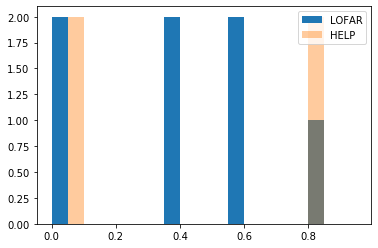

In [587]:
pvals = np.array([ks_test[n][1] for n in range(len(ks_test))])
mask = np.array([sign[n]<0 for n in range(len(ks_test))])
print(np.sum(mask))

bins=np.arange(0,1,0.05)
plt.hist(pvals[mask],bins=bins,label='LOFAR')
plt.hist(pvals[~mask],alpha=0.4,bins=bins,label='HELP')
plt.legend()
plt.show()

It seems that more of the runs are made worse by the addition of the LOFAR source. This could be due to teh fact that some of teh hecked LOFAR sources were not at the center of the rerun areas and shouldn't be included in this analysis. Alternatively they could be caused by not removing HELP prior list sources that are close to the LOFAR position are in fact the same object. It is alos worth checking how many of these sources are flagged.

In [588]:
mask = ((pvals<0.1) & (np.array(sign)>0))
ids = np.array(sources_done)[mask]

In [591]:
ids[:,0]

array(['ILTJ160631.79+533328.4', 'ILTJ160632.42+535312.7'], dtype='<U67')

In [625]:
mask = np.array([lofar['Source_Name'][n] in ids[:,0] for n in range(len(lofar))])
lofar[mask]

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,flo

In [651]:
mask = np.array([lofar['Source_Name'][n] in ids[:,0] for n in range(len(lofar))])
mask_help = np.array(['ILTJ' not in name for name in spire_prior['help_id']])

ra1 = lofar['RA'][mask].data
dec1 = lofar['DEC'][mask].data
c_lofar = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
ra2 = spire_prior[mask_help]['ra'].data
dec2 = spire_prior[mask_help]['dec'].data
c_help = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)

In [652]:
idx, d2d, _ = c_lofar.match_to_catalog_3d(c_help)

In [679]:
d2d.value*3600

array([8.85288768, 0.53726026])

In [646]:
spire_prior[mask_help][idx]

ra,dec,help_id,flag_optnir_det,f_mips_24
deg,deg,,,
float64,float64,bytes1728,float64,float64
241.633345518057,53.5602528894993,HELP_J160632.003+533336.910,7.0,83.35624
241.634887876057,53.8866663254993,HELP_J160632.373+535311.999,7.0,188.88588


In [663]:
mask = np.array([lofar['Source_Name'][n] in ids[:,0] for n in range(len(lofar))])
lofar[mask]

Source_Name,RA_radio,DEC_radio,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,RA,DEC,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float

In [670]:
np.sqrt((spire_prior[mask_help]['ra'][idx] - lofar[mask]['RA'])**2 + (spire_prior[mask_help]['dec'][idx] - lofar[mask]['DEC'])**2)

0.0025737833204344716
0.00022646272951420848


In [647]:
fir_results = Table.read('data/data_release/XID+_lofar_ELAIS-N1_v0.5_20200113.fits')
fir_results[0]

Source_Name,RA_1,Dec_1,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_MIPS_24,XID+_rerun_mips,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,XID+_rerun_pacs,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_SPIRE_250,flag_SPIRE_350,flag_SPIRE_500,XID+_rerun_SPIRE,RA_2,Dec_2
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,degrees,degrees
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,bool,float64,float64
ILTJ155958.68+550534.6,239.9942929896559,55.0930282279941,205.18457,228.756,173.11113,-0.0048937183,5.1907605e-06,1.0001951,1720.3978,0.0,False,True,13.686264,29.31476,3.9415781,28.06837,54.981026,7.879433,0.00039258535,-0.000111965506,2.447301e-05,4.2142652e-05,0.9989418,1.0007188,1852.0857,1699.2491,0.0,0.0,False,False,True,17.912243,22.077332,11.550629,10.159505,14.491438,4.6809864,5.3084693,10.596807,1.6260326,-3.6218169,-5.9298606,-10.56029,1.6782023,2.3311257,3.1217968,0.99999154,0.9995658,0.9994741,1694.5498,3158.945,2915.309,0.0,0.006,0.0,False,False,False,True,239.9942929896559,55.0930282279941


In [648]:
mask = np.array([fir_results['Source_Name'][n] in ids[:,0] for n in range(len(lofar))])
fir_results[mask]

Source_Name,RA_1,Dec_1,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_MIPS_24,XID+_rerun_mips,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,XID+_rerun_pacs,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_SPIRE_250,flag_SPIRE_350,flag_SPIRE_500,XID+_rerun_SPIRE,RA_2,Dec_2
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,degrees,degrees
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,bool,float64,float64
ILTJ160631.79+533328.4,241.63240127602214,53.55785856964596,139.40654,152.57236,125.80265,-0.008628315,5.678302e-06,1.0010839,1839.5613,0.0,False,True,505.093,848.83435,154.64854,495.10226,850.5362,160.2065,0.0003700712,0.00028647913,1.5934671e-05,3.0291836e-05,0.9986685,1.0000228,2022.121,2046.8435,0.0,0.0,False,False,True,18.568398,21.471191,15.278345,17.671902,21.55261,13.164418,4.1613607,9.212549,1.1198759,-5.376118,-8.13945,-14.33662,1.713389,1.9629346,2.8974302,1.0043263,1.0034049,1.0008461,1244.4514,1531.951,1124.0032,0.402,0.971,0.914,False,True,True,True,241.63240127602214,53.55785856964596
ILTJ160632.42+535312.7,241.63467703041178,53.88674896617783,27.647942,67.293106,7.8619094,-0.008628315,5.678302e-06,1.0020936,669.48193,0.0,False,True,5.216146,12.286726,1.4603329,13.660359,26.773956,4.031015,0.0003700712,0.00028647913,1.5934671e-05,3.0291836e-05,0.9992862,0.9996314,3006.478,2155.9358,0.0,0.0,True,True,True,1.1069832,2.3648944,0.30737677,0.7565049,1.7585099,0.1949429,3.2264853,6.7503157,0.9701535,-5.376118,-8.13945,-14.33662,1.713389,1.9629346,2.8974302,0.99880826,0.9990413,0.99845105,2777.8098,1896.7283,3245.8894,0.0,0.002,0.045,True,True,True,True,241.63467703041178,53.88674896617783


In [700]:
spire_prior[mask_help][idx]['help_id'].data.astype(str)

'HELP_J160632.003+533336.910'

In [703]:
tmp = join(spire_prior[mask_help][idx],mips_rerun,keys='help_id',join_type='left')

In [704]:
tmp

ra,dec,help_id,flag_optnir_det,f_mips_24,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
deg,deg,,,,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
float64,float64,bytes1728,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
241.633345518057,53.5602528894993,HELP_J160632.003+533336.910,7.0,83.35624,241.633345518057,53.5602528894993,4.347597,7.546662,1.6384114,6.3795586,10.436497,2.553909,5.6535044,10.004055,2.058704,-5.376118,-8.13945,-14.33662,1.713389,1.9629346,2.8974302,1.007578,1.0033625,1.0006714,1235.9204,1909.732,1089.373,0.201,0.94,0.823
241.633345518057,53.5602528894993,HELP_J160632.003+533336.910,7.0,83.35624,241.633345518057,53.5602528894993,4.347597,7.546662,1.6384114,6.3795586,10.436497,2.553909,5.6535044,10.004055,2.058704,-5.376118,-8.13945,-14.33662,1.713389,1.9629346,2.8974302,1.007578,1.0033625,1.0006714,1235.9204,1909.732,1089.373,0.214,0.94,0.826
241.634887876057,53.8866663254993,HELP_J160632.373+535311.999,7.0,188.88588,241.634887876057,53.8866663254993,1.1716162,2.4604836,0.3631903,0.7994201,1.9006553,0.21085715,3.8228528,7.2883134,1.1853582,-5.376118,-8.13945,-14.33662,1.713389,1.9629346,2.8974302,0.9988651,0.9991804,1.0000795,2677.7778,1615.1843,2654.8428,0.0,0.0,0.039
241.634887876057,53.8866663254993,HELP_J160632.373+535311.999,7.0,188.88588,241.634887876057,53.8866663254993,1.1706898,2.458891,0.32113388,0.70048517,1.7004275,0.18724844,5.0502186,10.348976,1.4748124,-6.0444427,-9.715552,-17.598797,1.4347057,1.6468006,3.0741308,0.99906194,0.99960846,1.0030655,1217.8441,1684.2229,2470.9868,0.0,0.007,0.054
241.634887876057,53.8866663254993,HELP_J160632.373+535311.999,7.0,188.88588,241.634887876057,53.8866663254993,1.1716162,2.4604836,0.3631903,0.7994201,1.9006553,0.21085715,3.8228528,7.2883134,1.1853582,-5.376118,-8.13945,-14.33662,1.713389,1.9629346,2.8974302,0.9988651,0.9991804,1.0000795,2677.7778,1615.1843,2654.8428,0.001,0.002,0.042


In [102]:
fname = 'data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

In [103]:
imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header

im250=hdulist['image'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['image'].header)
hdulist.close()

imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE350_v1.0.fits'
hdulist = fits.open(pswfits)
im350phdu=hdulist[0].header
im350hdu=hdulist['image'].header

im350=hdulist['image'].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist['image'].header)
hdulist.close()

imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE500_v1.0.fits'
hdulist = fits.open(pswfits)
im500phdu=hdulist[0].header
im500hdu=hdulist['image'].header

im500=hdulist['image'].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist['image'].header)
hdulist.close()

In [104]:
plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['red','cyan','orange'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}

contours are at [-6.85467488e-05 -2.97247045e-05  9.09733980e-06  4.79193841e-05
  8.67414284e-05  1.25563473e-04  1.64385517e-04]
plotting 5 sources
plotting 1 sources
plotting 1 sources


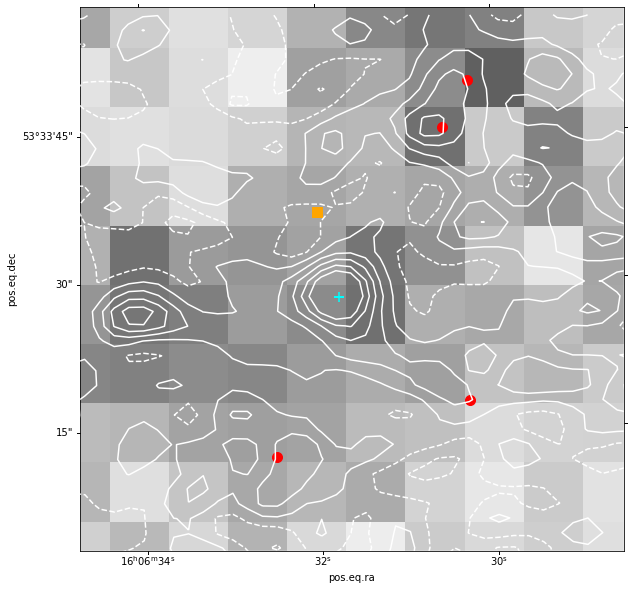

contours are at [-6.85467488e-05 -2.97247045e-05  9.09733980e-06  4.79193841e-05
  8.67414284e-05  1.25563473e-04  1.64385517e-04]
plotting 5 sources
plotting 1 sources
plotting 1 sources


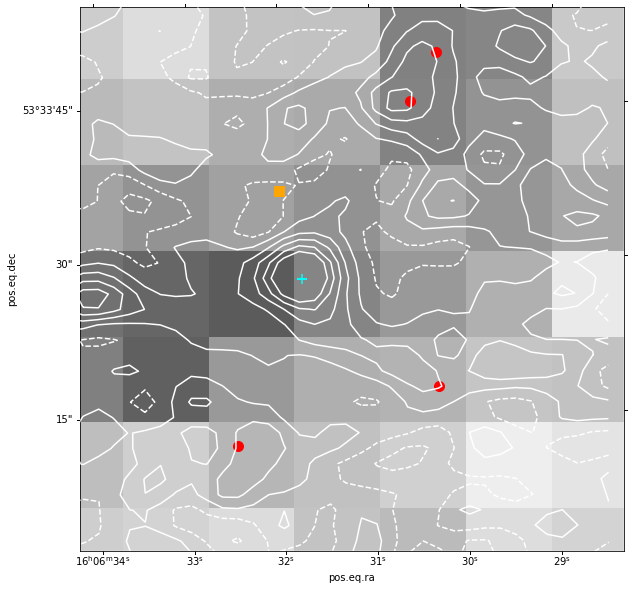

contours are at [-6.85467488e-05 -2.97247045e-05  9.09733980e-06  4.79193841e-05
  8.67414284e-05  1.25563473e-04  1.64385517e-04]
plotting 5 sources
plotting 1 sources
plotting 1 sources


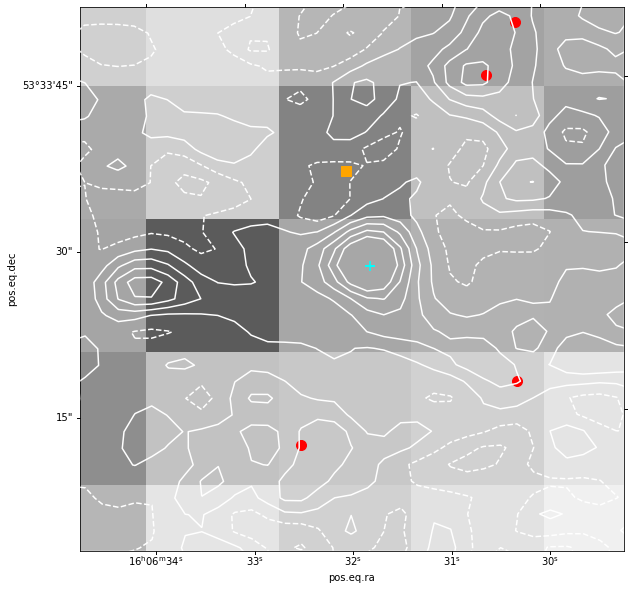

contours are at [-2.15753423e-04 -1.03404458e-04  8.94450764e-06  1.21293473e-04
  2.33642438e-04  3.45991403e-04  4.58340368e-04]
plotting 6 sources
plotting 1 sources
plotting 1 sources


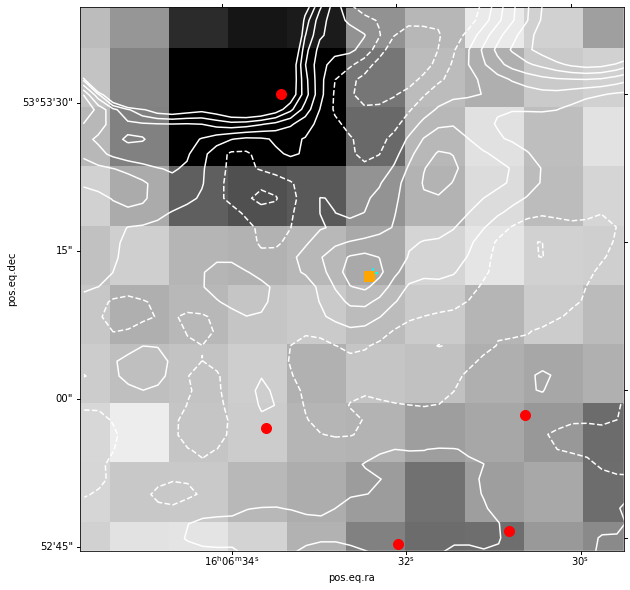

contours are at [-2.15753423e-04 -1.03404458e-04  8.94450764e-06  1.21293473e-04
  2.33642438e-04  3.45991403e-04  4.58340368e-04]
plotting 6 sources
plotting 1 sources
plotting 1 sources


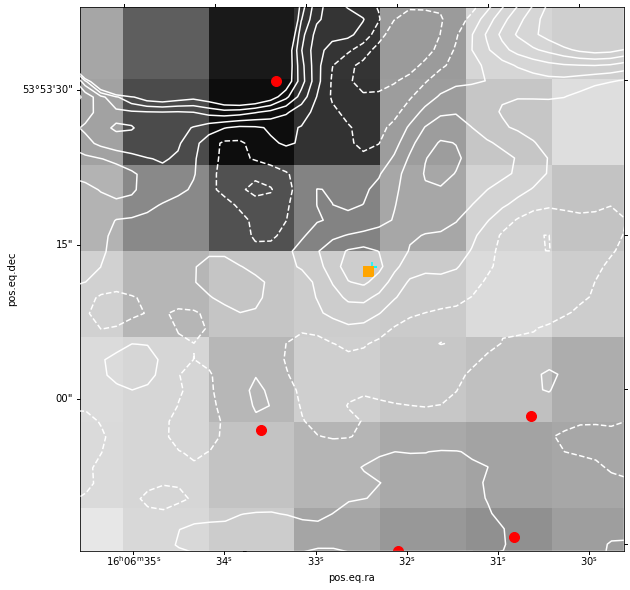

contours are at [-2.15753423e-04 -1.03404458e-04  8.94450764e-06  1.21293473e-04
  2.33642438e-04  3.45991403e-04  4.58340368e-04]
plotting 6 sources
plotting 1 sources
plotting 1 sources


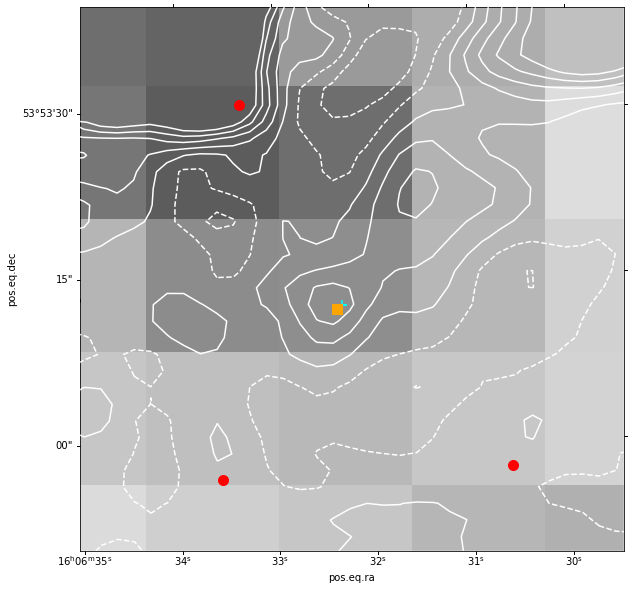

In [681]:
mask_help = np.array(['ILTJ' not in name for name in spire_prior['help_id']])

ras = lofar[mask]['RA']
decs = lofar[mask]['DEC']
for n,ra in enumerate(ras):
    image_plotting.plot_figure(im250,[spire_prior[mask_help],lofar,spire_prior[mask_help][idx]],w_250,ras[n],decs[n],plot_params,contour_data=[radim_data,radim_wcs])
    image_plotting.plot_figure(im350,[spire_prior[mask_help],lofar,spire_prior[mask_help][idx]],w_350,ras[n],decs[n],plot_params,contour_data=[radim_data,radim_wcs])
    image_plotting.plot_figure(im500,[spire_prior[mask_help],lofar,spire_prior[mask_help][idx]],w_500,ras[n],decs[n],plot_params,contour_data=[radim_data,radim_wcs])

### Read in the finished KS tests

In [8]:
f = open('data/fir/SPIRE/KS_lofar_rerun.pkl','rb')
KS_results = pickle.load(f)

In [26]:
len(KS_results[1])

8370

In [28]:
KS_table = Table()
col_id = Column(data = np.array(KS_results[2])[:,0], name='Source_Name')
col_KS_stat = Column(data=np.array([KS_results[0][n].statistic for n in range(len(KS_results[0]))]), name='KS_statistic')
col_KS_pval = Column(data=np.array([KS_results[0][n].pvalue for n in range(len(KS_results[0]))]), name='KS_pval')
col_KS_sign = Column(data=np.array([KS_results[1][n] for n in range(len(KS_results[0]))]), name='KS_sign')
col_lofar_tile = Column(data = np.array(KS_results[2])[:,1], name='lofar_file')
col_help_tile = Column(data = np.array(KS_results[2])[:,2], name='help_file')
KS_table.add_columns([col_id,col_KS_stat,col_KS_pval,col_KS_sign,col_lofar_tile,col_help_tile])

In [29]:
KS_table

Source_Name,KS_statistic,KS_pval,KS_sign,lofar_file,help_file
str67,float64,float64,float64,str67,str67
ILTJ160631.79+533328.4,0.3333333333333333,0.07088798787114439,0.601,data/fir/SPIRE/xidplus_run_85/lofar_xidplus_fir_85_rerun.pkl,/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_649754_9.pkl
ILTJ160632.09+533128.9,0.13333333333333333,0.9578462903438838,-0.21500000000000002,data/fir/SPIRE/xidplus_run_85/lofar_xidplus_fir_85_rerun.pkl,/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_649754_9.pkl
ILTJ160632.20+533644.2,0.26666666666666666,0.23907300248018645,-0.291,data/fir/SPIRE/xidplus_run_85/lofar_xidplus_fir_85_rerun.pkl,/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_649754_9.pkl
ILTJ160632.42+535312.7,0.13333333333333333,0.9578462903438838,0.278,data/fir/SPIRE/xidplus_run_85/lofar_xidplus_fir_85_rerun.pkl,/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_649779_9.pkl
ILTJ160629.92+535921.4,0.13333333333333333,0.9578462903438838,0.067,data/fir/SPIRE/xidplus_run_85/lofar_xidplus_fir_85_rerun.pkl,/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_649785_9.pkl
ILTJ160630.86+540801.3,0.06666666666666667,0.9999999909208507,-0.027999999999999914,data/fir/SPIRE/xidplus_run_85/lofar_xidplus_fir_85_rerun.pkl,/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_649790_9.pkl
ILTJ160630.66+543844.1,0.1,0.9988393756362763,0.14399999999999996,data/fir/SPIRE/xidplus_run_85/lofar_xidplus_fir_85_rerun.pkl,/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_649887_9.pkl
ILTJ160630.25+544301.4,0.06666666666666667,0.9999999909208507,0.052000000000000046,data/fir/SPIRE/xidplus_run_85/lofar_xidplus_fir_85_rerun.pkl,/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_649930_9.pkl
ILTJ160630.70+550442.8,0.2,0.5940706297759378,0.13699999999999996,data/fir/SPIRE/xidplus_run_85/lofar_xidplus_fir_85_rerun.pkl,/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_649961_9.pkl


4295


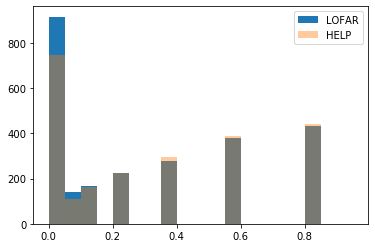

In [31]:
pvals = KS_table['KS_pval']
mask = KS_table['KS_sign']<0
print(np.sum(mask))

bins=np.arange(0,1,0.05)
plt.hist(pvals[mask],bins=bins,label='LOFAR')
plt.hist(pvals[~mask],alpha=0.4,bins=bins,label='HELP')
plt.legend()
plt.show()

In [87]:
joined_ks_lofar = join(KS_table,lofar_xid,join_type='inner',keys='Source_Name')
joined_ks_lofar = join(joined_ks_lofar,lofar,join_type='inner',keys='Source_Name')
joined_ks_lofar[0]

Source_Name,KS_statistic,KS_pval,KS_sign,lofar_file,help_file,RA_1,Dec_1,F_MIPS_24_1,FErr_MIPS_24_u_1,FErr_MIPS_24_l_1,Bkg_MIPS_24_1,Sig_conf_MIPS_24_1,Rhat_MIPS_24_1,n_eff_MIPS_24_1,Pval_res_24_1,flag_MIPS_24,XID+_rerun_mips,F_PACS_100_1,FErr_PACS_100_u_1,FErr_PACS_100_l_1,F_PACS_160_1,FErr_PACS_160_u_1,FErr_PACS_160_l_1,Bkg_PACS_100_1,Bkg_PACS_160_1,Sig_conf_PACS_100_1,Sig_conf_PACS_160_1,Rhat_PACS_100_1,Rhat_PACS_160_1,n_eff_PACS_100_1,n_eff_PACS_160_1,Pval_res_100_1,Pval_res_160_1,flag_PACS_100_1,flag_PACS_160_1,XID+_rerun_pacs,F_SPIRE_250_1,FErr_SPIRE_250_u_1,FErr_SPIRE_250_l_1,F_SPIRE_350_1,FErr_SPIRE_350_u_1,FErr_SPIRE_350_l_1,F_SPIRE_500_1,FErr_SPIRE_500_u_1,FErr_SPIRE_500_l_1,Bkg_SPIRE_250_1,Bkg_SPIRE_350_1,Bkg_SPIRE_500_1,Sig_conf_SPIRE_250_1,Sig_conf_SPIRE_350_1,Sig_conf_SPIRE_500_1,Rhat_SPIRE_250_1,Rhat_SPIRE_350_1,Rhat_SPIRE_500_1,n_eff_SPIRE_250_1,n_eff_SPIRE_500_1,n_eff_SPIRE_350_1,Pval_res_250_1,Pval_res_350_1,Pval_res_500_1,flag_SPIRE_250,flag_SPIRE_350,flag_SPIRE_500,XID+_rerun_SPIRE,RA_2,Dec_2,RA_radio,DEC_radio,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,RA,DEC,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24_2,FErr_MIPS_24_u_2,FErr_MIPS_24_l_2,Bkg_MIPS_24_2,Sig_conf_MIPS_24_2,Rhat_MIPS_24_2,n_eff_MIPS_24_2,Pval_res_24_2,flag_mips_24,F_PACS_100_2,FErr_PACS_100_u_2,FErr_PACS_100_l_2,F_PACS_160_2,FErr_PACS_160_u_2,FErr_PACS_160_l_2,Bkg_PACS_100_2,Bkg_PACS_160_2,Sig_conf_PACS_100_2,Sig_conf_PACS_160_2,Rhat_PACS_100_2,Rhat_PACS_160_2,n_eff_PACS_100_2,n_eff_PACS_160_2,Pval_res_100_2,Pval_res_160_2,flag_PACS_100_2,flag_PACS_160_2,F_SPIRE_250_2,FErr_SPIRE_250_u_2,FErr_SPIRE_250_l_2,F_SPIRE_350_2,FErr_SPIRE_350_u_2,FErr_SPIRE_350_l_2,F_SPIRE_500_2,FErr_SPIRE_500_u_2,FErr_SPIRE_500_l_2,Bkg_SPIRE_250_2,Bkg_SPIRE_350_2,Bkg_SPIRE_500_2,Sig_conf_SPIRE_250_2,Sig_conf_SPIRE_350_2,Sig_conf_SPIRE_500_2,Rhat_SPIRE_250_2,Rhat_SPIRE_350_2,Rhat_SPIRE_500_2,n_eff_SPIRE_250_2,n_eff_SPIRE_500_2,n_eff_SPIRE_350_2,Pval_res_250_2,Pval_res_350_2,Pval_res_500_2,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_

2988


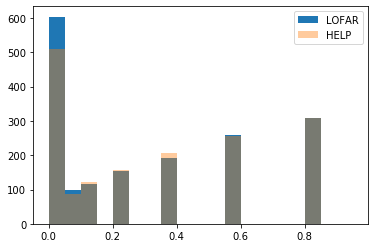

In [36]:
mask = ~joined_ks_lofar['flag_SPIRE_250']
pvals = KS_table['KS_pval'][mask]
signs = KS_table['KS_sign'][mask]
mask = signs<0
print(np.sum(mask))

bins=np.arange(0,1,0.05)
plt.hist(pvals[mask],bins=bins,label='LOFAR')
plt.hist(pvals[~mask],alpha=0.4,bins=bins,label='HELP')
plt.legend()
plt.show()

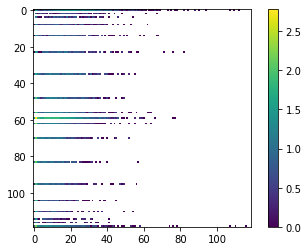

In [80]:
ras = joined_ks_lofar['RA_1'].data
decs = joined_ks_lofar['Dec_1'].data
mask_ks = abs(decs)<=90
lofar_coord = SkyCoord(ra=ras[mask_ks]*u.deg,dec=decs[mask_ks]*u.deg)

mask = np.array(['ILTJ' in name for name in spire_prior['help_id']])
ras = spire_prior['ra'][~mask]
decs = spire_prior['dec'][~mask]
prior_coord = SkyCoord(ra=ras,dec=decs)

idx,d2d,_ = lofar_coord.match_to_catalog_sky(prior_coord)

x = d2d.value*3600
y = 1-joined_ks_lofar[mask_ks]['KS_pval']
sign = joined_ks_lofar[mask_ks]['KS_sign']
mask = np.array([n>=0 for n in sign])
sign[mask] = 1
sign[~mask] = -1
y = y*sign

bins_x = np.linspace(-1,1,120)
bins_y = np.linspace(0,60,120)
data_num,xbin,ybin = np.histogram2d(y,x,bins=[bins_x,bins_y])
plt.imshow(np.log10(data_num))
plt.colorbar()
plt.show()

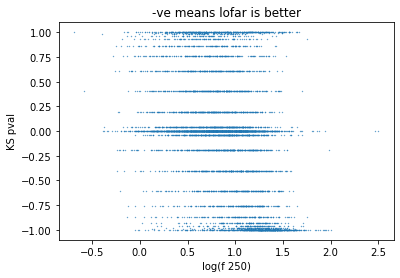

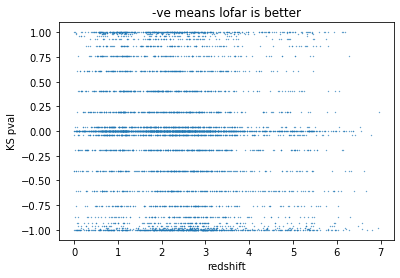

In [101]:
ras = joined_ks_lofar['RA_1'].data
decs = joined_ks_lofar['Dec_1'].data
mask_ks = abs(decs)<=90
lofar_coord = SkyCoord(ra=ras[mask_ks]*u.deg,dec=decs[mask_ks]*u.deg)

mask = np.array(['ILTJ' in name for name in spire_prior['help_id']])
ras = spire_prior['ra'][~mask]
decs = spire_prior['dec'][~mask]
prior_coord = SkyCoord(ra=ras,dec=decs)

idx,d2d,_ = lofar_coord.match_to_catalog_sky(prior_coord)

x = np.log10(joined_ks_lofar[mask_ks]['F_SPIRE_250_1'])
y = 1-joined_ks_lofar[mask_ks]['KS_pval']
sign = joined_ks_lofar[mask_ks]['KS_sign']
mask = np.array([n>=0 for n in sign])
sign[mask] = 1
sign[~mask] = -1
y = y*sign

plt.scatter(x,y,s=0.1)
plt.xlabel('log(f 250)')
plt.ylabel('KS pval')
plt.title('-ve means lofar is better')
plt.show()

x = joined_ks_lofar['Z_BEST'][mask_ks]

y = y
plt.scatter(x,y,s=0.1)
plt.xlabel('redshift')
plt.ylabel('KS pval')
plt.title('-ve means lofar is better')
plt.show()

In [114]:
joined_ks_lofar[mask]

Source_Name,KS_statistic,KS_pval,KS_sign,lofar_file,help_file,RA_1,Dec_1,F_MIPS_24_1,FErr_MIPS_24_u_1,FErr_MIPS_24_l_1,Bkg_MIPS_24_1,Sig_conf_MIPS_24_1,Rhat_MIPS_24_1,n_eff_MIPS_24_1,Pval_res_24_1,flag_MIPS_24,XID+_rerun_mips,F_PACS_100_1,FErr_PACS_100_u_1,FErr_PACS_100_l_1,F_PACS_160_1,FErr_PACS_160_u_1,FErr_PACS_160_l_1,Bkg_PACS_100_1,Bkg_PACS_160_1,Sig_conf_PACS_100_1,Sig_conf_PACS_160_1,Rhat_PACS_100_1,Rhat_PACS_160_1,n_eff_PACS_100_1,n_eff_PACS_160_1,Pval_res_100_1,Pval_res_160_1,flag_PACS_100_1,flag_PACS_160_1,XID+_rerun_pacs,F_SPIRE_250_1,FErr_SPIRE_250_u_1,FErr_SPIRE_250_l_1,F_SPIRE_350_1,FErr_SPIRE_350_u_1,FErr_SPIRE_350_l_1,F_SPIRE_500_1,FErr_SPIRE_500_u_1,FErr_SPIRE_500_l_1,Bkg_SPIRE_250_1,Bkg_SPIRE_350_1,Bkg_SPIRE_500_1,Sig_conf_SPIRE_250_1,Sig_conf_SPIRE_350_1,Sig_conf_SPIRE_500_1,Rhat_SPIRE_250_1,Rhat_SPIRE_350_1,Rhat_SPIRE_500_1,n_eff_SPIRE_250_1,n_eff_SPIRE_500_1,n_eff_SPIRE_350_1,Pval_res_250_1,Pval_res_350_1,Pval_res_500_1,flag_SPIRE_250,flag_SPIRE_350,flag_SPIRE_500,XID+_rerun_SPIRE,RA_2,Dec_2,RA_radio,DEC_radio,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,RA,DEC,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24_2,FErr_MIPS_24_u_2,FErr_MIPS_24_l_2,Bkg_MIPS_24_2,Sig_conf_MIPS_24_2,Rhat_MIPS_24_2,n_eff_MIPS_24_2,Pval_res_24_2,flag_mips_24,F_PACS_100_2,FErr_PACS_100_u_2,FErr_PACS_100_l_2,F_PACS_160_2,FErr_PACS_160_u_2,FErr_PACS_160_l_2,Bkg_PACS_100_2,Bkg_PACS_160_2,Sig_conf_PACS_100_2,Sig_conf_PACS_160_2,Rhat_PACS_100_2,Rhat_PACS_160_2,n_eff_PACS_100_2,n_eff_PACS_160_2,Pval_res_100_2,Pval_res_160_2,flag_PACS_100_2,flag_PACS_160_2,F_SPIRE_250_2,FErr_SPIRE_250_u_2,FErr_SPIRE_250_l_2,F_SPIRE_350_2,FErr_SPIRE_350_u_2,FErr_SPIRE_350_l_2,F_SPIRE_500_2,FErr_SPIRE_500_u_2,FErr_SPIRE_500_l_2,Bkg_SPIRE_250_2,Bkg_SPIRE_350_2,Bkg_SPIRE_500_2,Sig_conf_SPIRE_250_2,Sig_conf_SPIRE_350_2,Sig_conf_SPIRE_500_2,Rhat_SPIRE_250_2,Rhat_SPIRE_350_2,Rhat_SPIRE_500_2,n_eff_SPIRE_250_2,n_eff_SPIRE_500_2,n_eff_SPIRE_350_2,Pval_res_250_2,Pval_res_350_2,Pval_res_500_2,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_

600
ILTJ160246.40+544346.8
contours are at [-5.15930195e-05 -2.19303890e-05  7.73224148e-06  3.73948720e-05
  6.70575025e-05  9.67201330e-05  1.26382764e-04]
plotting 5 sources
plotting 1 sources


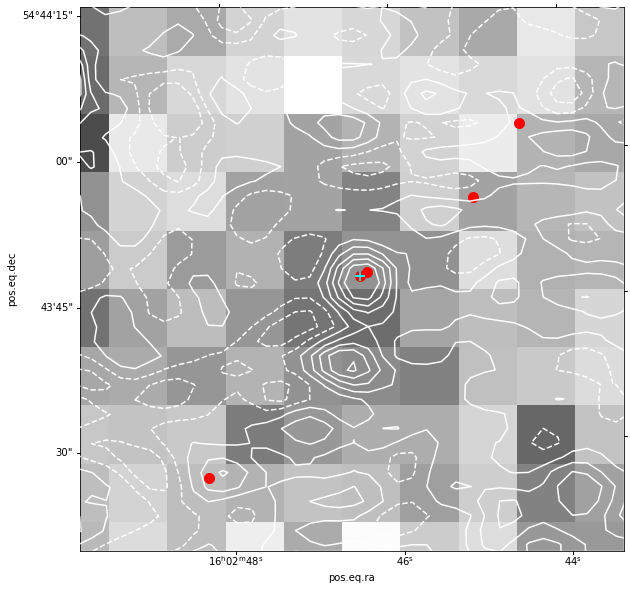

ILTJ160253.20+544352.1
contours are at [-5.51829154e-05 -1.97880623e-05  1.56067907e-05  5.10016437e-05
  8.63964968e-05  1.21791350e-04  1.57186203e-04]
plotting 9 sources
plotting 1 sources


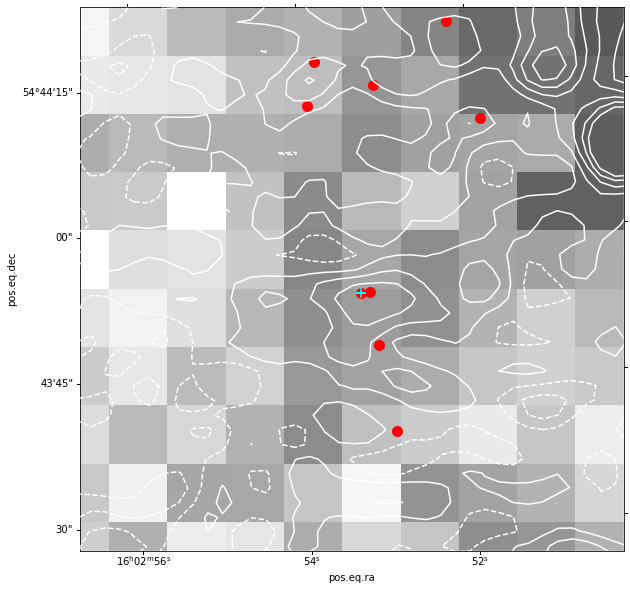

ILTJ160253.87+552858.5
contours are at [-5.79110049e-05 -2.73828023e-05  3.14540031e-06  3.36736029e-05
  6.42018055e-05  9.47300081e-05  1.25258211e-04]
plotting 5 sources
plotting 1 sources


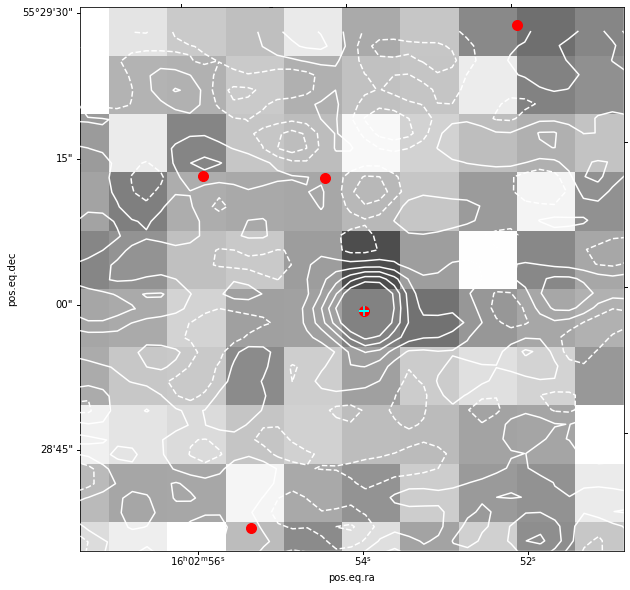

ILTJ160258.78+544105.7
contours are at [-3.89913233e-05 -1.17685309e-05  1.54542615e-05  4.26770539e-05
  6.98998464e-05  9.71226388e-05  1.24345431e-04]
plotting 8 sources
plotting 1 sources


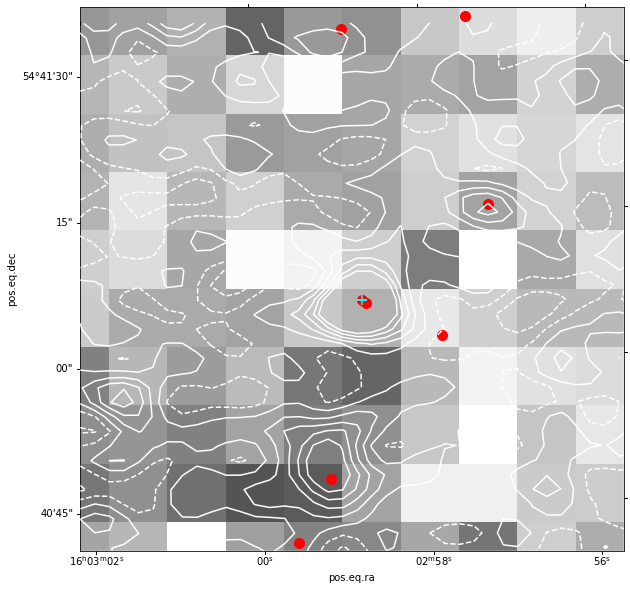

ILTJ160259.38+544413.0


ValueError: Latitude angle(s) must be within -90 deg <= angle <= 90 deg, got 1e+20 deg

<Figure size 720x720 with 0 Axes>

In [113]:
ras = joined_ks_lofar['RA_1'].data
decs = joined_ks_lofar['Dec_1'].data
ids = joined_ks_lofar['Source_Name'].data

mask = (joined_ks_lofar['KS_pval']<0.01) & (joined_ks_lofar['KS_sign']>0)
ras = ras[mask]
decs = decs[mask]
ids = ids[mask]
print(np.sum(mask))
for n,ra in enumerate(ras[:10]):
    print(ids[n])
    image_plotting.plot_figure(im250,[spire_prior,lofar],w_250,ras[n],decs[n],plot_params,contour_data=[radim_data,radim_wcs])

In [476]:
pixels_lofar = find_pixels(ra_target,dec_target,18/3600,priors,posterior)
pixels_help = find_pixels(ra_target,dec_target,18/3600,priors_help,posterior_help)

Ks_2sampResult(statistic=0.2, pvalue=0.5940706297759378)


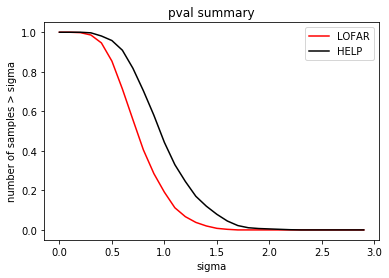

Ks_2sampResult(statistic=0.03333333333333333, pvalue=1.0)


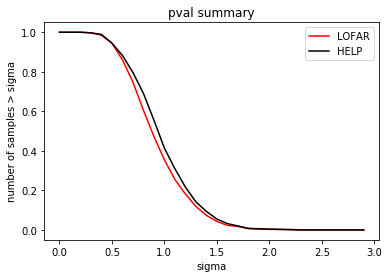

Ks_2sampResult(statistic=0.13333333333333333, pvalue=0.9578462903438838)


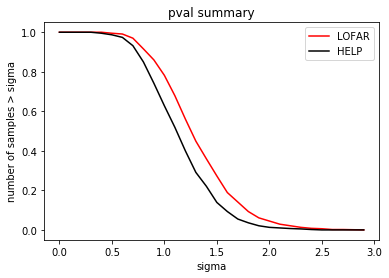

Ks_2sampResult(statistic=0.06666666666666667, pvalue=0.9999999909208507)


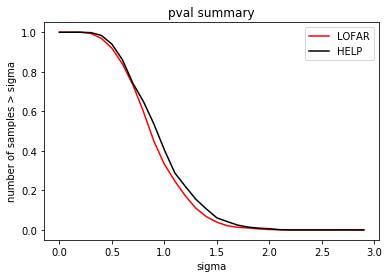

Ks_2sampResult(statistic=0.03333333333333333, pvalue=1.0)


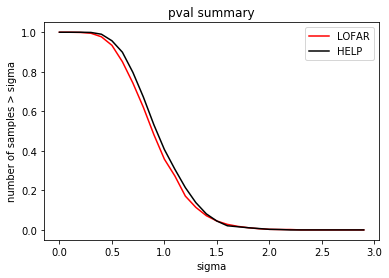

Ks_2sampResult(statistic=0.4, pvalue=0.015643390496754332)


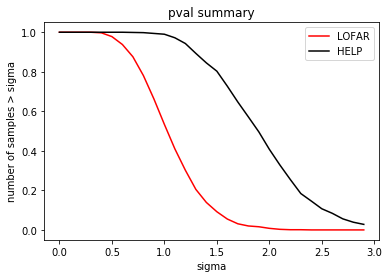

Ks_2sampResult(statistic=0.13333333333333333, pvalue=0.9578462903438838)


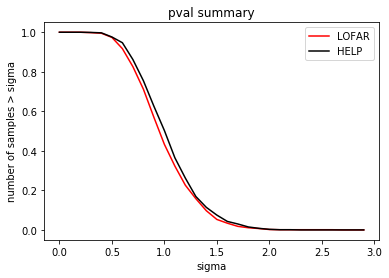

In [486]:
for n,source in enumerate(pixels_lofar):
    sigmas = np.arange(0,3,0.1)
    y_lofar = []
    y_help = []
    for sigma in sigmas:
        y_lofar.append(pval_summary(pixels_lofar[n],sigma,rep_map_new[0],priors[0]))
        y_help.append(pval_summary(pixels_help[n],sigma,rep_map_old[0],priors_help[0]))
    
    print(ks_2samp(np.array(y_lofar),np.array(y_help)))
    #plt.plot(sigmas,y_lofar,c='red',label='LOFAR')
    #plt.plot(sigmas,y_help,c='black',label='HELP')
    #plt.xlabel('sigma')
    #plt.ylabel('number of samples > sigma')
    #plt.title('pval summary')
    #plt.legend()
    #plt.show()

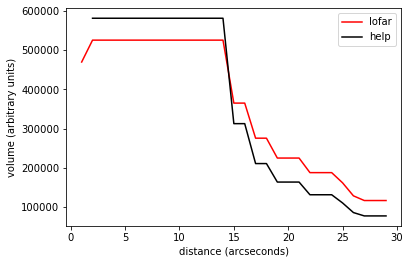

In [470]:
name = priors[0].ID[-1]
ra_target = priors[0].sra[-1]
dec_target = priors[0].sdec[-1]

ras_lofar = priors[0].sra
decs_lofar = priors[0].sdec
dist_lofar = (ras_lofar - ra_target)**2 + (decs_lofar - dec_target)**2

ras_help = priors_help[0].sra
decs_help = priors_help[0].sdec
dist_help = (ras_help - ra_target)**2 + (decs_help - dec_target)**2

seperation = np.arange(0,30,1)
volumes_lofar = []
volumes_help = []
for sep in seperation:

    mask = dist_lofar<(sep/3600)**2
    names = priors[0].ID[mask]

    volumes_lofar.append(posterior_volume(names,priors,posterior))
    
    mask = dist_help<(sep/3600)**2
    names = priors_help[0].ID[mask]

    volumes_help.append(posterior_volume(names,priors,posterior))
    
plt.plot(seperation,volumes_lofar,c='red',label='lofar') 
plt.plot(seperation,volumes_help,c='black',label='help')
plt.xlabel('distance (arcseconds)')
plt.ylabel('volume (arbitrary units)')
plt.legend()
plt.show()

In [488]:
files_done = glob.glob('/lustre/scratch/astro/im281/fitIR/data/*.pkl')
nums_done = []
for file in files_done:
    nums_done.append(file.replace('.pkl','').split('_')[-1])

In [492]:
file.replace('.pkl','').split('_')[-1]

'2954'

In [368]:
pval_map_sum(ra_target,dec_target,priors,priors_help,posterior,posterior_help,18/3600)

number of pixel within radius is: 15
number of pixel within radius is: 16
number of pixel within radius is: 16
number of pixel within radius is: 15
number of pixel within radius is: 16
number of pixel within radius is: 16
number of pixel within radius is: 18
number of pixel within radius is: 15
number of pixel within radius is: 16
number of pixel within radius is: 16
number of pixel within radius is: 15
number of pixel within radius is: 16
number of pixel within radius is: 16
number of pixel within radius is: 18


([-4.21942160779242,
  0.6721791533405941,
  -6.6257868743062875,
  -7.571218227393261,
  -3.278632414197344,
  3.4063173348820444,
  2.7165838856446594],
 [-1.3509736701438302,
  1.2525467831868262,
  -5.111760085927878,
  -6.000114268893222,
  -2.6520178052314236,
  17.011659504497857,
  2.4880799617129066])

In [236]:
#replace the ras, decs and ids with your sources
ids = mips_rerun['help_id']
mask = np.array(['ILTJ' in name for name in ids])

ras = mips_rerun['RA']
decs = mips_rerun['Dec']
ids_lofar_run = ids

filenames = glob.glob('/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_*_9.pkl')
tiles = [int(name.split('/')[-1].split('_')[1]) for name in filenames]
healpixids,filepaths = get_xidplus_posterior(ids_lofar_run,9,tiles,ras=ras,decs=decs,filepath='/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/')

of the 235628 sources given, 235628 are within the tile list you have


In [237]:
ids,counts = np.unique(healpixids,return_counts=True)
best_tile = ids[np.argmax(counts)]
best_file = filepaths[np.argmax(counts)]

mask = healpixids==best_tile
ra = ras[mask][0]
dec = decs[mask][0]

In [40]:
test = glob.glob('data/fir/SPIRE_no_help/*/*.pkl')
test.sort()
len(test)

837

loading new lofar and HELP posterior
loading new both posterior


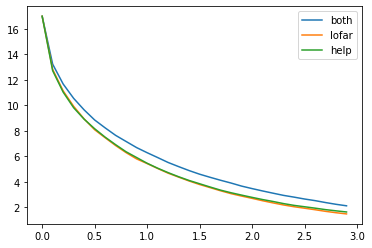

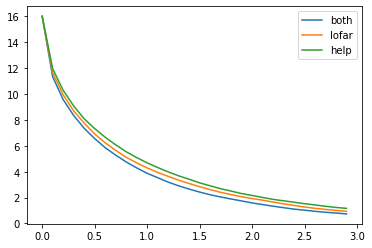

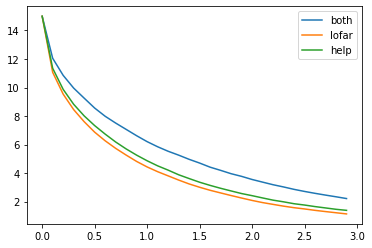

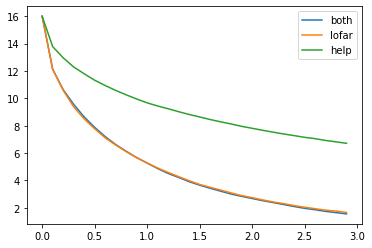

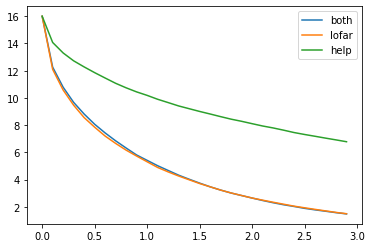

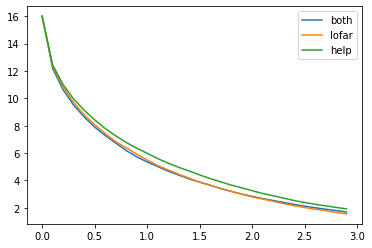

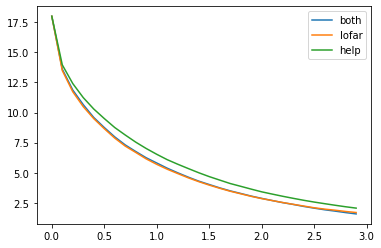

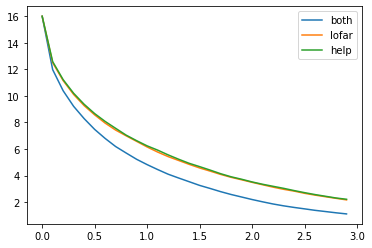

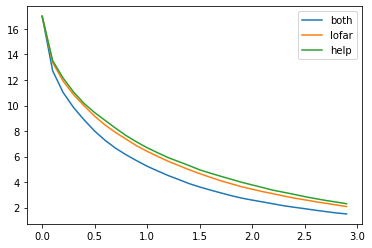

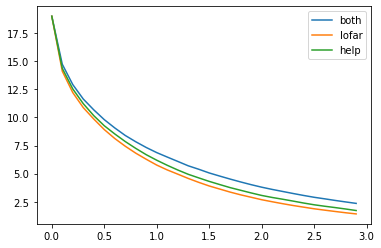

loading new lofar and HELP posterior


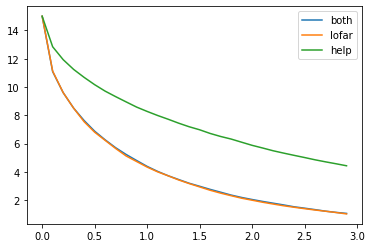

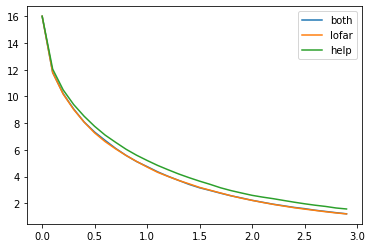

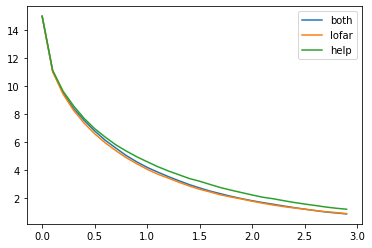

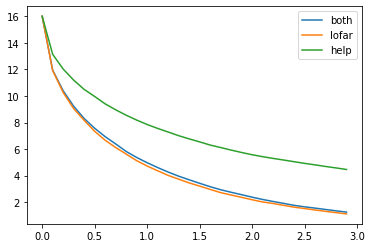

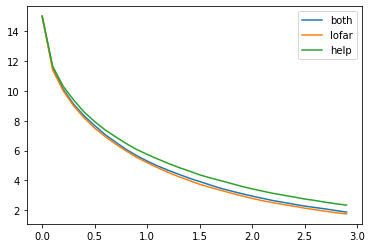

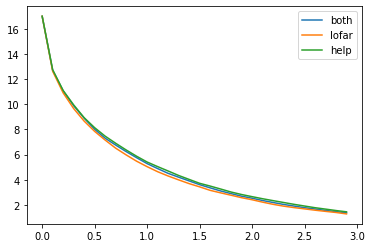

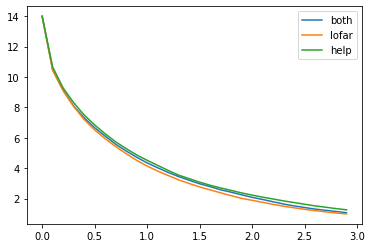

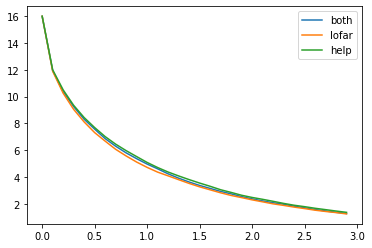

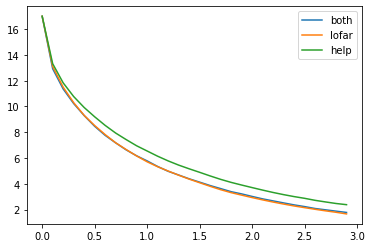

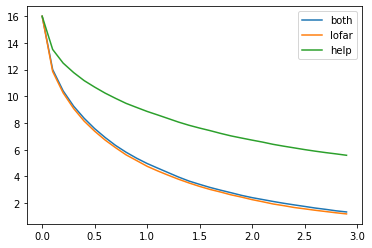

loading new lofar and HELP posterior
loading new both posterior


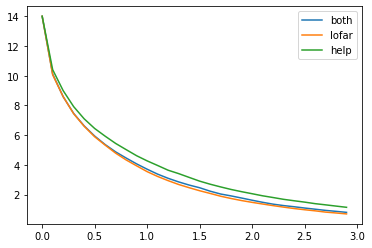

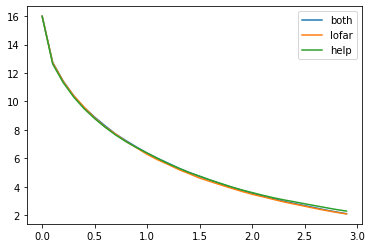

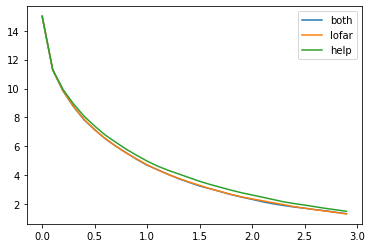

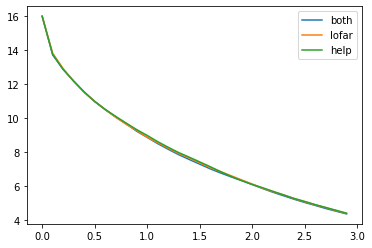

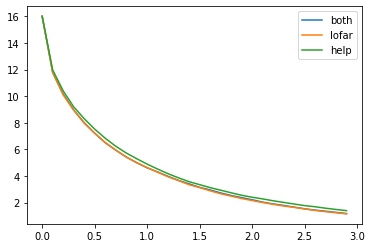

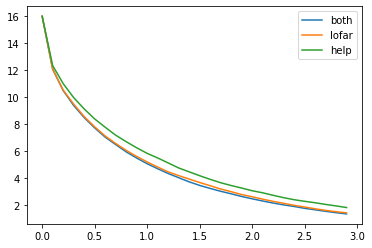

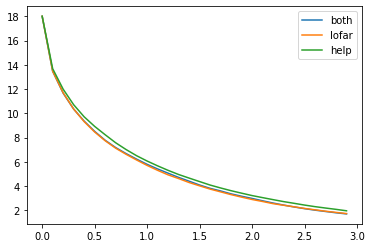

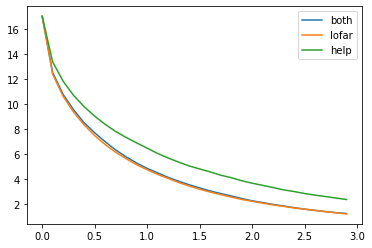

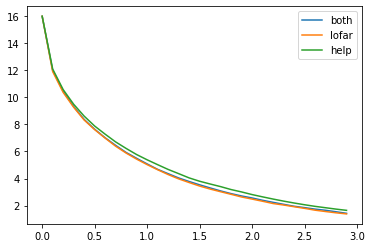

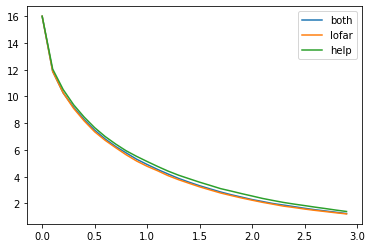

loading new lofar and HELP posterior


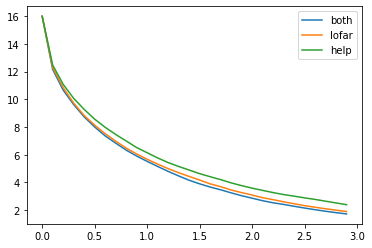

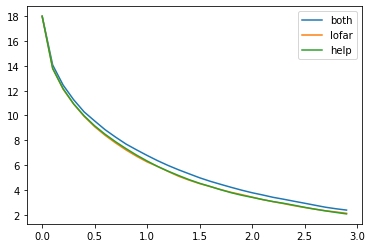

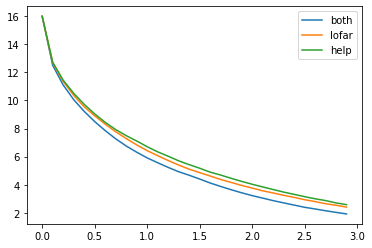

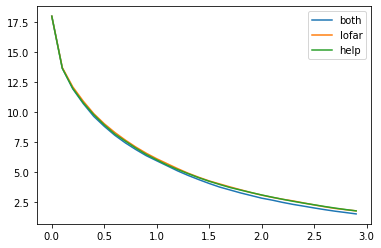

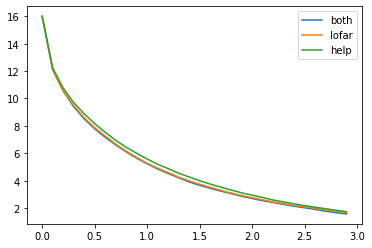

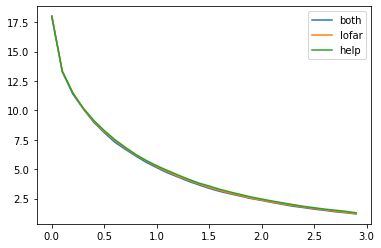

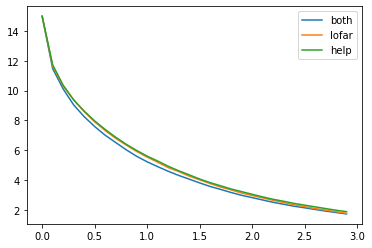

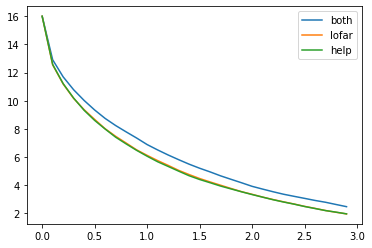

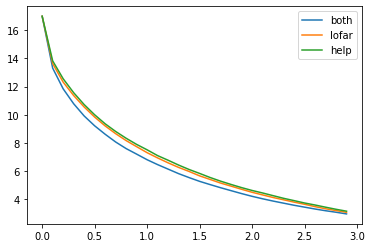

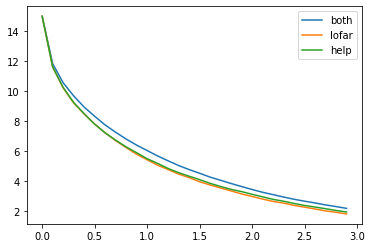

In [18]:
ras = lofar['RA']
mask = np.isnan(ras)
ras[mask] = lofar['RA_radio'][mask]

decs = lofar['DEC']
mask = np.isnan(decs)
decs[mask] = lofar['DEC_radio'][mask]

ids_centre = lofar['Source_Name']

sources_done = []
both_result = []
lofar_result = []
help_result = []

for n,name in enumerate(ids_centre[:40]):
    if n%10==0:
        print('loading new lofar and HELP posterior')
        lofar_file = 'data/fir/SPIRE_no_help/xidplus_run_{}/lofar_xidplus_fir_{}_rerun.pkl'.format(int(n/10),int(n/10))
        priors_lofar,posterior_lofar = xidplus.load(lofar_file)
        rep_map_lofar = postmaps.replicated_maps(priors_lofar,posterior_lofar)
        
        help_file = 'data/fir/SPIRE_no_lofar/xidplus_run_{}/lofar_xidplus_fir_{}_rerun.pkl'.format(int(n/10),int(n/10))
        priors_help,posterior_help = xidplus.load(help_file)
        rep_map_help = postmaps.replicated_maps(priors_help,posterior_help)
    if n%20==0:
        print('loading new both posterior')
        both_file = 'data/fir/SPIRE/xidplus_run_{}/lofar_xidplus_fir_{}_rerun.pkl'.format(int(n/20),int(n/20))
        priors_both,posterior_both = xidplus.load(both_file)
        rep_map_both = postmaps.replicated_maps(priors_both,posterior_both)
        
    ra_target = ras[n]
    dec_target = decs[n]
    
    pixels_both = find_pixels([ra_target],[dec_target],18/3600,priors_both,posterior_both)
    pixels_lofar = find_pixels([ra_target],[dec_target],18/3600,priors_lofar,posterior_lofar)
    pixels_help = find_pixels([ra_target],[dec_target],18/3600,priors_help,posterior_help)
    
    for n,source in enumerate(pixels_lofar):
        sigmas = np.arange(0,3,0.1)
        y_both = []
        y_lofar = []
        y_help = []
        for sigma in sigmas:
            y_both.append(pval_summary(pixels_both,sigma,rep_map_both[0],priors_both[0]))
            y_lofar.append(pval_summary(pixels_lofar,sigma,rep_map_lofar[0],priors_lofar[0]))
            y_help.append(pval_summary(pixels_help,sigma,rep_map_help[0],priors_help[0]))
    
        both_result.append(y_both)
        lofar_result.append(y_lofar)
        help_result.append(y_help)
    
        plt.plot(sigmas,y_both,label='both')
        plt.plot(sigmas,y_lofar,label='lofar')
        plt.plot(sigmas,y_help,label='help')
        plt.legend()
        plt.show()

        sources_done.append([name,both_file,lofar_file,help_file])
        

In [25]:
ks_test = []
sign = []

for n in range(len(help_result)):

    ks_test.append(ks_2samp(np.array(both_result[n]),np.array(help_result[n])))
            
    diff = np.array(both_result[n]) - np.array(help_result[n])
    abs_diff = abs(diff)
    sign.append(diff[np.argmax(abs_diff)])
sign = np.array(sign)
mask = sign<0
sign[mask] = -1

mask = sign>0
sign[mask] = 1

(array([ 7.,  1.,  0.,  4.,  4., 21.,  2.,  0.,  0.,  1.]),
 array([-0.99999999, -0.82390729, -0.6478146 , -0.4717219 , -0.2956292 ,
        -0.1195365 ,  0.0565562 ,  0.2326489 ,  0.4087416 ,  0.5848343 ,
         0.760927  ]),
 <a list of 10 Patch objects>)

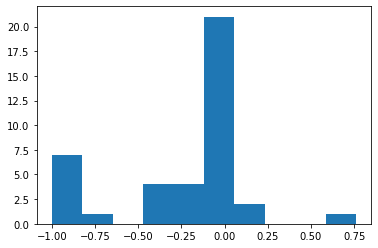

In [26]:
y = (1-np.array([tmp.pvalue for tmp in ks_test])) * sign

plt.hist(y)

In [23]:
mask = np.array(sign)<0
sign[mask] = -1

mask = sign>0
sign[mask] = 1

array([ 1., -1.,  1., -5., -5., -1., -1., -1., -2.,  1., -4., -1., -0.,
       -3., -1., -0., -0., -0., -1., -4., -1., -0., -0., -0., -0., -1.,
       -0., -2., -0., -0., -1.,  0., -1., -0., -0., -0., -0.,  1., -1.,
        1.])